In [1]:
import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install unrar
import unrar
!unrar x '/content/drive/MyDrive/Yolov5 Formatted Data (with test).rar'

Streaming output truncated to the last 5000 lines.
Extracting  Yolo Formatted Data (with test)/labels/train/5722_0317115034_01_WRI-R2_F013.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5723_0248151065_01_WRI-R1_F012.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5723_0248151099_01_WRI-R2_F012.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5724_0753805015_01_WRI-R1_M004.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5725_0537135025_01_WRI-R1_F017.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5725_0538330523_02_WRI-R2_F017.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5726_0957811427_01_WRI-L1_M011.txt      99%  OK 
Extracting  Yolo Formatted Data (with test)/labels/train/5726_0957811462_01_WRI-L2_M011.txt      99%  OK 
Extracting  Yolo Formatted Da

In [5]:
import os
import csv
import shutil

def copy_files(folder_directory, csv_path, output_directory):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Read the CSV file
    with open(csv_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:
            filestem = row[reader.fieldnames[0]]  # Extract the value from the first column
            fracture_visible = row[reader.fieldnames[13]]  # Assuming the second column contains fracture_visible value

            # Check if the filestem ends with ".png"
            if not filestem.endswith('.png'):
                filestem += '.png'

            # Determine the source folder based on the fracture_visible value
            if fracture_visible == '1':
                destination_folder = '1'
            else:
                destination_folder = '0'

            # Search for the file in the train, test, and val folders
            for folder_name in ['train', 'test', 'val']:
                source_path = os.path.join(folder_directory, folder_name, filestem)
                if os.path.exists(source_path):
                    break

            print(f"source path: {source_path}")
            # Copy the file to the output directory
            if os.path.exists(source_path):
                destination_path = os.path.join(output_directory, destination_folder, filestem)
                os.makedirs(os.path.dirname(destination_path), exist_ok=True)
                shutil.copy(source_path, destination_path)
                print(f"Copied {filestem} to {destination_path}")
            else:
                print(f"File {filestem} not found in any folder")

# Example usage
folder_directory = '/content/Yolo Formatted Data (with test)/images'
csv_path = '/content/dataset.csv'
output_directory = '/content/dataset'

copy_files(folder_directory, csv_path, output_directory)

Streaming output truncated to the last 5000 lines.
source path: /content/Yolo Formatted Data (with test)/images/train/5328_0387304575_01_WRI-L2_F011.png
Copied 5328_0387304575_01_WRI-L2_F011.png to /content/dataset/0/5328_0387304575_01_WRI-L2_F011.png
source path: /content/Yolo Formatted Data (with test)/images/test/5328_0476911826_02_WRI-R1_F014.png
Copied 5328_0476911826_02_WRI-R1_F014.png to /content/dataset/0/5328_0476911826_02_WRI-R1_F014.png
source path: /content/Yolo Formatted Data (with test)/images/train/5328_0476911872_02_WRI-R2_F014.png
Copied 5328_0476911872_02_WRI-R2_F014.png to /content/dataset/0/5328_0476911872_02_WRI-R2_F014.png
source path: /content/Yolo Formatted Data (with test)/images/train/5329_0558345445_01_WRI-L1_F004.png
Copied 5329_0558345445_01_WRI-L1_F004.png to /content/dataset/1/5329_0558345445_01_WRI-L1_F004.png
source path: /content/Yolo Formatted Data (with test)/images/test/5329_0558345475_01_WRI-L2_F004.png
Copied 5329_0558345475_01_WRI-L2_F004.png to 

In [6]:
print("0", len(os.listdir('/content/dataset/0')))
print("1", len(os.listdir('/content/dataset/1')))

0 6777
1 13549


In [7]:
import os
import shutil
import random

def create_data_split(folder_directory, train_ratio=0.75, test_ratio=0.05, val_ratio=0.2):
    # Create the data folder
    data_folder = os.path.join(folder_directory, 'data')
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    else:
        print("The 'data' folder already exists. Please remove or rename it.")
        return

    # Get the subfolder paths
    subfolders = ['0', '1']
    subfolder_paths = [os.path.join(folder_directory, subfolder) for subfolder in subfolders]

    # Create the train, test, and val folders
    for split in ['train', 'test', 'val']:
        split_folder = os.path.join(data_folder, split)
        os.makedirs(split_folder)
        for subfolder in subfolders:
            class_folder = os.path.join(split_folder, subfolder)
            os.makedirs(class_folder)

    # Split the data
    for subfolder_path in subfolder_paths:
        images = os.listdir(subfolder_path)
        random.shuffle(images)

        train_end = int(len(images) * train_ratio)
        test_end = train_end + int(len(images) * test_ratio)

        train_images = images[:train_end]
        test_images = images[train_end:test_end]
        val_images = images[test_end:]

        for image in train_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'train', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

        for image in test_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'test', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

        for image in val_images:
            src = os.path.join(subfolder_path, image)
            dst = os.path.join(data_folder, 'val', os.path.basename(subfolder_path), image)
            shutil.copy(src, dst)

    print("Data split completed successfully!")

# Example usage
folder_directory = '/content/dataset'
create_data_split(folder_directory)


Data split completed successfully!


In [8]:
# Just some helper methods, that we will use later down the road

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

In [9]:
img_height = 120
img_width = 50
classes = ['0', '1']
class_names = ['No-Fracture', 'Fracture']

In [10]:
print("Train 0", len(os.listdir("/content/dataset/data/train/0")))
print("Train 1", len(os.listdir("/content/dataset/data/train/1")))
print("Val 0", len(os.listdir("/content/dataset/data/val/0")))
print("Val 1", len(os.listdir("/content/dataset/data/val/1")))
print("Test 0", len(os.listdir("/content/dataset/data/test/0")))
print("Test 1", len(os.listdir("/content/dataset/data/test/1")))

Train 0 5082
Train 1 10161
Val 0 1357
Val 1 2711
Test 0 338
Test 1 677


In [11]:
data_dir = '/content/dataset/data/train'

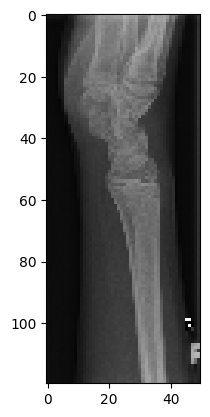

In [12]:
img_index = randint(0, 3000)
class_index = randint(0, 1)

img = cv.imread(os.path.join(os.path.join(data_dir, classes[class_index]),
                             os.listdir(os.path.join(data_dir, classes[class_index]))[img_index]), cv.IMREAD_GRAYSCALE)
r_img = resize_image(img, img_width, img_height)

plt.imshow(r_img, cmap='gray')
plt.show()

In [13]:
# Creating training data
def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in os.listdir(path):
            try:
              img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
              resized_img_array = resize_image(img_array, img_width, img_height)
              data.append([resized_img_array, class_num])
            except:
              continue

    return data

In [14]:
training_data = get_data(data_dir, classes, img_width, img_height)

In [15]:
# Shuffling the training data (IMPORTANT)
shuffle(training_data)

In [16]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [17]:
X_train, y_train = sep_features_labels(training_data)

In [18]:
#Reshaping the features
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    # y_train = preprocessing.LabelEncoder().fit_transform(y_train)
    y = np.asarray(y).astype('float32').reshape((-1,1))

    return X, y

In [19]:
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

In [ ]:
def pickle_save(x_name, y_name, X, y):
    pickle_out = open(f'{x_name}.pickle', "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(f'{y_name}.pickle', 'wb')
    pickle.dump(y, pickle_out)
    pickle_out.close()

def pickle_load(x_name, y_name):
    pickle_in = open(x_name, 'rb')
    X = pickle.load(pickle_in)
    pickle_in.close()

    pickle_in = open(y_name, 'rb')
    y = pickle.load(pickle_in)
    pickle_in.close()
    return X, y

In [ ]:
pickle_save('X_train', 'y_train', X_train, y_train)

In [ ]:
X_train, y_train = pickle_load(r'D:\FYP\Loaded Pickle Data\X_train.pickle', r'D:\FYP\Loaded Pickle Data\y_train.pickle')

In [20]:
def getConvModel(input_shape, num_kernels, hidden_neurons, num_layers):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # for i in range(0, num_layers - 1):
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(hidden_neurons, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [21]:
conv_model = getConvModel(X_train.shape[1:], 64, 128, 4)

In [22]:
val_data = get_data('/content/dataset/data/val', classes, img_width, img_height)
shuffle(val_data)
X_val, y_val = sep_features_labels(val_data)
X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [23]:
print(len(X_val), len(y_val))

4068 4068


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/drive/MyDrive/checkpoint.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_weights_only=False,
    save_best_only=True,  # Save only the best model based on validation loss
    save_freq='epoch',
    verbose=1
)

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)

# Train the model with the checkpoint and early stopping callbacks
history = conv_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=132,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7132
Epoch 1: val_accuracy improved from -inf to 0.66642, saving model to /content/drive/MyDrive/checkpoint.h5
116/116 [==============================] - 18s 40ms/step - loss: 0.5485 - accuracy: 0.7132 - val_loss: 0.6337 - val_accuracy: 0.6664
Epoch 2/100
114/116 [============================>.] - ETA: 0s - loss: 0.4973 - accuracy: 0.7561
Epoch 2: val_accuracy improved from 0.66642 to 0.66691, saving model to /content/drive/MyDrive/checkpoint.h5
116/116 [==============================] - 3s 23ms/step - loss: 0.4972 - accuracy: 0.7560 - val_loss: 0.6059 - val_accuracy: 0.6669
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 0.4727 - accuracy: 0.7706
Epoch 3: val_accuracy improved from 0.66691 to 0.68019, saving model to /content/drive/MyDrive/checkpoint.h5
116/116 [==============================] - 3s 23ms/step - loss: 0.4726 - accuracy: 0.7707 - val_loss: 0.5670 - val_accur

In [25]:
# Save the final model
final_model_filepath = '/content/drive/MyDrive/final_model.h5'
conv_model.save(final_model_filepath)

# Save the history object
history_filepath = '/content/drive/MyDrive/history.pkl'
import pickle
with open(history_filepath, 'wb') as f:
    pickle.dump(history.history, f)

print("Model and history saved successfully!")

Model and history saved successfully!


In [26]:
from tensorflow import keras

final_model_filepath = '/content/drive/MyDrive/checkpoint.h5'

# Load the model
loaded_model = keras.models.load_model(final_model_filepath)

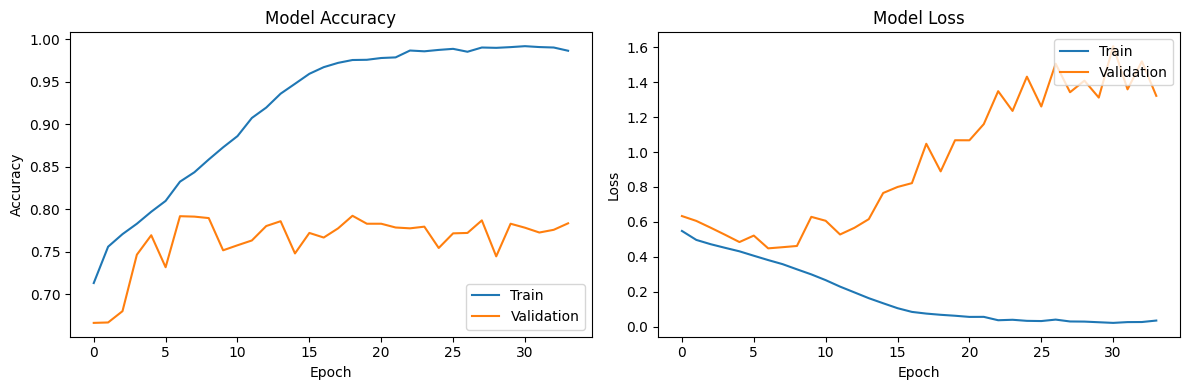

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage
# history_filepath = '/path/to/history.pkl'
# import pickle
# with open(history_filepath, 'rb') as f:
#     history = pickle.load(f)

plot_history(history)

In [28]:
# Load testing data
testing_data = get_data(r'/content/dataset/data/test', classes, img_width, img_height)
X_test, y_test = sep_features_labels(testing_data)
X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [29]:
from sklearn.metrics import classification_report

# Assuming you have the test data (X_test, y_test) available

# Make predictions on the test data
y_pred = conv_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (assuming binary classification)

# Calculate the classification metrics
classification_metrics = classification_report(y_test, y_pred)

print("Classification Metrics:")
print(classification_metrics)


32/32 [==============================] - 0s 6ms/step
Classification Metrics:
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.68       338
         1.0       0.83      0.89      0.86       677

    accuracy                           0.80      1015
   macro avg       0.79      0.76      0.77      1015
weighted avg       0.80      0.80      0.80      1015



In [30]:
test_loss, test_acc = conv_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.8561 - accuracy: 0.8049


In [31]:
print(f'Loss = {test_loss}, Accuracy: {test_acc}')

Loss = 0.8560993671417236, Accuracy: 0.8049260973930359


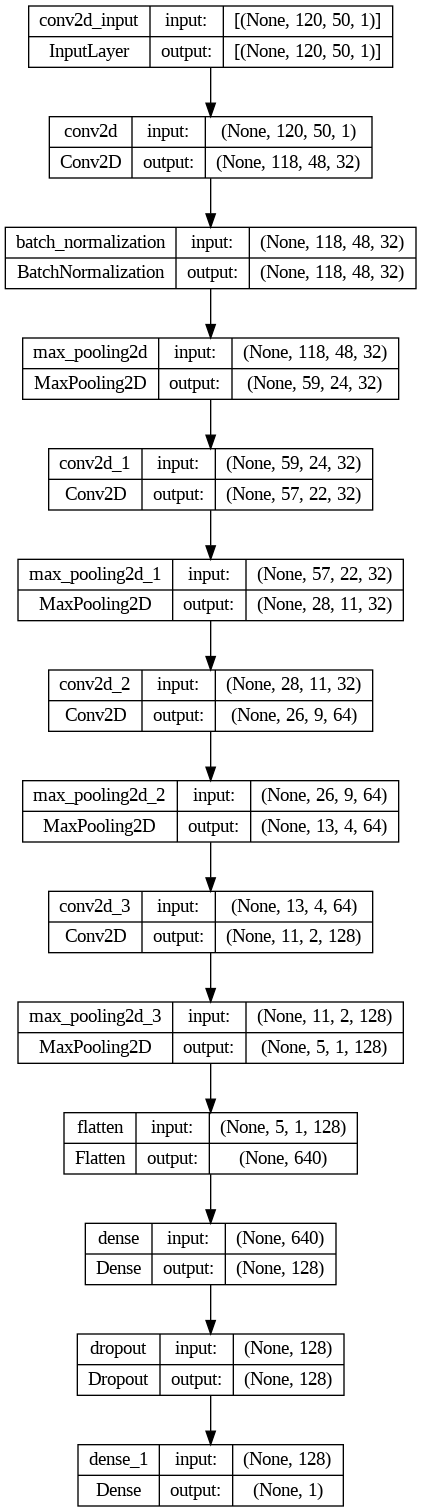

In [32]:
from tensorflow.keras.utils import plot_model

# Assuming you have already defined the conv_model

# Plot the model architecture
plot_model(conv_model, to_file='model_architecture.png', show_shapes=True)

# Display the plot
from PIL import Image
Image.open('model_architecture.png').show()


In [33]:
# Display the model layers
print(conv_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 48, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 118, 48, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 11, 32)       0         
 2D)                                                             
                                                        

ValueError: ignored

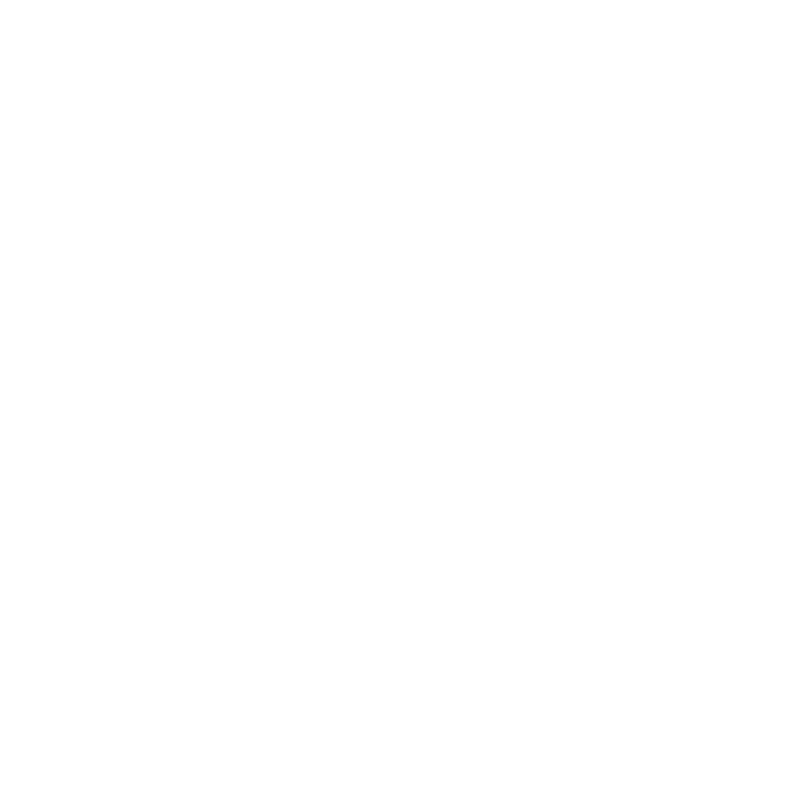

In [38]:
model_summary = []
conv_model.summary(print_fn=lambda x: model_summary.append(x))

import matplotlib.pyplot as plt

# Determine the number of columns in the model summary table
num_columns = len(model_summary[0].split())  # Split by whitespace

# Save the model summary as a PNG image
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
table = ax.table(cellText=model_summary, loc='center', cellLoc='left', colLabels=["Layer (type)", "Output Shape", "Param #"] * num_columns)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.savefig('model_summary.png', bbox_inches='tight')
plt.close(fig)

In [32]:
from sklearn.metrics import classification_report

# Assuming you have the test data (X_test, y_test) available

# Make predictions on the test data
y_pred = loaded_model .predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions (assuming binary classification)

# Calculate the classification metrics
classification_metrics = classification_report(y_test, y_pred)

print("Classification Metrics:")
print(classification_metrics)


32/32 [==============================] - 0s 4ms/step
Classification Metrics:
              precision    recall  f1-score   support

         0.0       0.76      0.66      0.70       338
         1.0       0.84      0.90      0.87       677

    accuracy                           0.82      1015
   macro avg       0.80      0.78      0.79      1015
weighted avg       0.81      0.82      0.81      1015



In [ ]:
def normalize_img(img):
    r_img = resize_image(img, img_width, img_height)
    r_img = img_to_array(r_img, data_format='channels_last')
    r_img = np.array(r_img).reshape(-1, img_height, img_width, 1)
    r_img = (np.array(r_img)).astype('float')/255.0
    return r_img

In [ ]:
def get_img(img_path):
     img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
     r_img = resize_image(img, img_width, img_height)
     return r_img

In [ ]:
def get_predicted_class(pred_prob):
    if pred_prob > .5:
        return classes[1]
    return classes[0]

In [ ]:
def predict_class(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    r_img = normalize_img(img)
    predict = conv_model.predict(r_img)
    pred_prob = predict[0][0]
    return pred_prob, get_predicted_class(pred_prob)

In [ ]:
test_data = []
for a_class in classes:
    path = os.path.join(r'D:\FYP\Dataset\Output Dataset\test', a_class)
    for img in os.listdir(path):
        test_data.append([os.path.join(path, img), a_class])
shuffle(test_data)

In [ ]:
def get_random_img(data):
    i = randint(0, len(data) - 1)
    return data[i][0], data[i][1]

In [ ]:
rand_img, actual_lbl = get_random_img(test_data)
print(f'Path: {rand_img}, Label: {actual_lbl}')

Path: D:\FYP\Dataset\Output Dataset\test\Pathological\1440_0853819663_01_WRI-R2_M013.png, Label: Pathological


In [ ]:
# set manual image path
# img_path = r'D:\FYP\Dataset\Output Dataset\test\No-Pathologies\1003_0408953722_01_WRI-R1_M011_0.png'
actual_lbl=''
rand_img, actual_lbl = get_random_img(test_data)
prob, class_label = predict_class(rand_img)
print(f'\nPredicted Label: {class_label}\nProbability of Pathology: {prob}\nActual Label: {actual_lbl}')

1/1 [==============================] - 0s 29ms/step

Predicted Label: Pathological
Probability of Pathology: 0.9763190150260925
Actual Label: Pathological
